<a href="https://colab.research.google.com/github/Trading-com-Dados/redes-sociais/blob/main/20220413_Quartas_de_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Quartas de Backtesting  - Trading com Dados**
---
#### *Disclaimer:*
#### Este código foi elaborado para fins exclusivamente educacionais. O conteúdo aqui apresentado visa fornecer informações complementares para auxiliar o investidor na tomada de suas próprias decisões de investimento. Reforçando, nenhum tópico aqui abordado constitui qualquer tipo de indicação/oferta/solicitação de compra/venda de qualquer produto.

<img src="https://tradingcomdados.com/images/logotipo/logotipo-trading-com-dados.svg" width="300">

# **1. Bibliotecas utilizadas**

In [1]:
!pip install yfinance python-binance
#!pip install MetaTrader5
!pip install ta
!pip install backtrader

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 27.7 MB/s 
     |████████████████████████████████| 288 kB 42.9 MB/s 
     |████████████████████████████████| 45 kB 2.5 MB/s 
     |████████████████████████████████| 1.1 MB 43.8 MB/s 
     |████████████████████████████████| 111 kB 22.9 MB/s 
     |████████████████████████████████| 271 kB 24.9 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 144 kB 32.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [37]:
import numpy as np
import pandas as pd

from datetime import datetime
import pytz

import yfinance as yf
from binance.client import Client
import ta
import backtrader as bt
#import MetaTrader5 as mt5

import matplotlib.pyplot as plt
# %matplotlib inline
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# **2. Piloto: obtenção de dados IBOV**

In [7]:
lista_ativos = ['^BVSP']

In [9]:
yf_cotacoes_df = yf.download(lista_ativos, start='2021-01-01', end='2021-12-31', period = "1d")
yf_cotacoes_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,119024.0,120354.0,118062.0,118558.0,118558.0,8741400
2021-01-05,118835.0,119790.0,116756.0,119223.0,119223.0,9257100
2021-01-06,119377.0,120924.0,118917.0,119851.0,119851.0,11638200
2021-01-07,119103.0,121983.0,119101.0,121956.0,121956.0,11774800
2021-01-08,122387.0,125324.0,122386.0,125077.0,125077.0,11085800
...,...,...,...,...,...,...
2021-12-23,105251.0,105453.0,104637.0,104891.0,104891.0,7283600
2021-12-27,104892.0,105694.0,104798.0,105531.0,105531.0,7594900
2021-12-28,105555.0,105652.0,104503.0,104864.0,104864.0,7509000


In [10]:
data = bt.feeds.PandasData(dataname=yf_cotacoes_df, name='IBOV')

In [63]:
class Setup_9_1(bt.Strategy):

    params = {'MM_p':9}
    
    ## Criar __init__ com todas os parâmetros que pretende usar
    def __init__(self):
      ema_MM = bt.indicators.EMA(self.datas[0],period=self.params.MM_p)
      preco_fech = self.datas[0]

      self.crossover = bt.indicators.CrossOver(preco_fech,ema_MM)
      self.ema_MM = bt.indicators.EMA(self.datas[0],period=self.params.MM_p)
      self.preco_fech = self.datas[0]
      self.Diff_preco_ema = (preco_fech - ema_MM)

    ## Criar uma função de registro (caso queira imprimir na tela algum parametro)
    def log(self, txt, dt=None):
      dt = self.datas[0].datetime.date(0)
      print(f'{dt}: {txt}')
  
    ## Criar uma "função de execução" que seguirá a série temporal dos dados
    def next(self):
      self.log('EMA (%.0fp) = %.2f || Preco_fech = %.2f || Posição crossover =  %.0f || Diff =  %.3f' % ((self.params.MM_p),(self.ema_MM[0]),(self.preco_fech[0]),(self.crossover[0]),(self.Diff_preco_ema[0])))

      if  self.crossover[-1] == 0 and self.crossover[0] > 0:
        self.log('BUY CREATE')
        self.buy()

      elif  self.crossover[-1] == 0 and self.crossover[0] < 0:
        self.log('SELL CREATE')
        self.sell()

In [64]:
## Instanciar o cérebro
cerebro = bt.Cerebro()

## Importar os dados de cotações
cerebro.adddata(data)

## Determinar a estratégia de execução
cerebro.addstrategy(Setup_9_1)

## Estabelecer parâmetros do broker
cerebro.broker.setcash(1000000)
print('Valor inicial da carteira: %.2f' % cerebro.broker.getvalue())

## Executar o backtesting
cerebro.run()

print('Valor final da carteira: %.2f' % cerebro.broker.getvalue())

Valor inicial da carteira: 1000000.00
2021-01-15: EMA (9p) = 121610.71 || Preco_fech = 120502.00 || Posição crossover =  -1 || Diff =  -1108.711
2021-01-18: EMA (9p) = 121536.97 || Preco_fech = 121242.00 || Posição crossover =  0 || Diff =  -294.969
2021-01-19: EMA (9p) = 121364.18 || Preco_fech = 120673.00 || Posição crossover =  0 || Diff =  -691.175
2021-01-20: EMA (9p) = 121032.94 || Preco_fech = 119708.00 || Posição crossover =  0 || Diff =  -1324.940
2021-01-21: EMA (9p) = 120514.95 || Preco_fech = 118443.00 || Posição crossover =  0 || Diff =  -2071.952
2021-01-22: EMA (9p) = 119846.36 || Preco_fech = 117172.00 || Posição crossover =  0 || Diff =  -2674.362
2021-01-26: EMA (9p) = 119169.89 || Preco_fech = 116464.00 || Posição crossover =  0 || Diff =  -2705.889
2021-01-27: EMA (9p) = 118512.31 || Preco_fech = 115882.00 || Posição crossover =  0 || Diff =  -2630.311
2021-01-28: EMA (9p) = 118672.65 || Preco_fech = 119314.00 || Posição crossover =  1 || Diff =  641.351
2021-01-28:

<IPython.core.display.Javascript object>

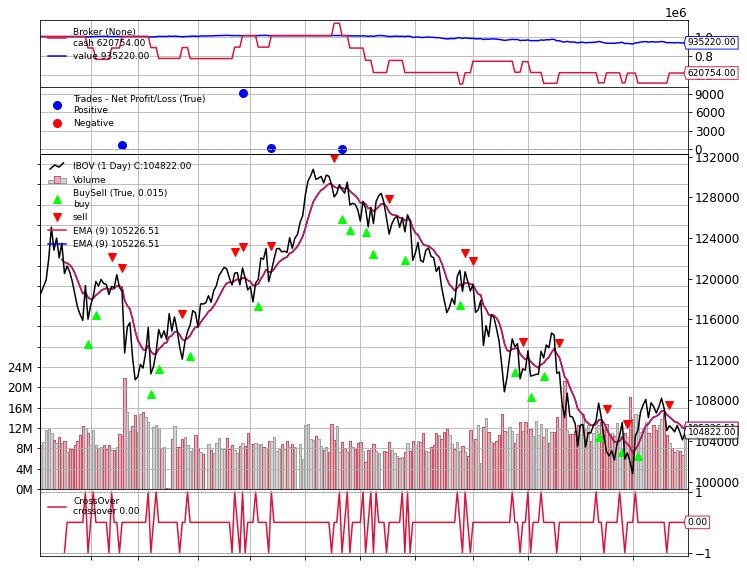

In [60]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams.update({'font.size': 12})
cerebro.plot(iplot = False);

In [ ]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close

        # Acompanhar as ordens pendentes
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        
        #Registrar o valor de fechamento
        self.log('Close, %.2f' % self.dataclose[0])

        # Checar se alguma ordem está pendente. Se sim, não é possível enviar uma segunda ordem
        if self.order:
            return

        # Checar se estamos posicionados no ativo
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()